# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

## Load *Dataset*
Load data from the given pickle file

In [8]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# load the data set

with open('/content/drive/MyDrive/Colab Notebooks/train_data.pkl','rb') as f:
    data= pickle.load(f)
X = data['X']
y = data['y']

Mounted at /content/drive


**Displaying Images**

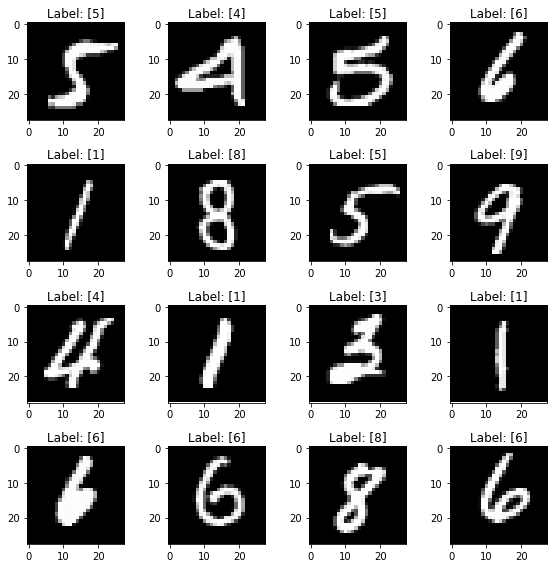

In [9]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
indices = [random.randrange(0,X.shape[0] - 1) for i in range(16)]
images = np.reshape(X[indices],(16,28,28))
labels = y[indices]
num_row = 4
num_col = 4
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(16):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Pre - Processing

**Normalization**

In [10]:
# normalize
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

**Splitting into train,test**

In [17]:
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.15, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


**One-Hot Encoding**

In [18]:
def one_hot(y):
    m=y.shape[0]
    Y = np.zeros((m,10))
    for i in range(m):
        for j in range(10):
            if y[i]==j:
                Y[i,j] = 1
            else:
                Y[i,j] = 0
    return Y
Y_train = one_hot(y_train)
Y_test = one_hot(y_test)


## Building up parts of our classifier

**Activation functions**

In [1]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (10, N)
    output: (10, N)
    """
    z = z - np.max(z)
    exponents = np.exp(z)
    return exponents/exponents.sum(axis=0,keepdims=True)

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [13]:
def init_params(n_x,n_h,n_y):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    W1 = np.random.randn(n_x,n_h) * 0.01
    b1 = np.zeros((n_h,1)) 
    W2 = np.random.randn(n_h,n_y) * 0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

**Forward Propagation**

In [2]:
def forward_propg(X, parameters):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    X = X.T
    W1 = (parameters["W1"]).T
    b1 = parameters["b1"]
    W2 = (parameters["W2"]).T
    b2 = parameters["b2"]

    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = softmax(Z2)
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    return A2, cache


**Cross entropy Loss with regularization**

In [3]:
def compute_cost(A2,Y,parameters,lambd):
    Y = Y.T
    m = A2.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    cost = - np.sum(Y*np.log(A2 + 10**-7))/m
    regul_cost = lambd/(2*m)*(np.sum(np.square(W1)) + np.sum(np.square(W2)))
    cost = cost + regul_cost
    return cost

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [4]:
def backward_propg(parameters, X, Y,cache,lambd):
    """
    calculate gradients
    """
    X = X.T
    Y = Y.T
    m = X.shape[1]
    W1 = (parameters["W1"]).T
    W2 = (parameters["W2"]).T
    Z1 = cache["Z1"]
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m + lambd/m*W2
    db2 = np.sum(dZ2,axis=1,keepdims=True) / m
    dZ1 = np.dot(W2.T,dZ2) * (Z1 >= 0)
    dW1 = np.dot(dZ1,X.T)/m + lambd/m*W1
    db1 = np.sum(dZ1,axis=1,keepdims=True) / m
    grads = {"dW1": dW1.T, "db1": db1, "dW2": dW2.T, "db2": db2}
    
    return grads
    

**Updating Parameters**

In [5]:
def update_parameters(parameters,grads,lr):
    W1 = (parameters["W1"]).T
    b1 = parameters["b1"]
    W2 = (parameters["W2"]).T
    b2 = parameters["b2"]

    dW1 = (grads["dW1"]).T
    db1 = grads["db1"]
    dW2 = (grads["dW2"]).T
    db2 = grads["db2"]

    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2

    parameters = {"W1": W1.T, "b1": b1, "W2": W2.T, "b2": b2}
    
    return parameters


**Mini-Batches**

In [6]:
def random_mini_batches(X, Y, mini_batch_size = 64):
            
    m = X.shape[0]                 
    mini_batches = []
    X = X.T
    Y = Y.T

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((10, m))
    
    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X =  shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y =  shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]

        mini_batch = (mini_batch_X.T, mini_batch_Y.T)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,- (m % mini_batch_size):]
        mini_batch_Y = shuffled_Y[:,- (m % mini_batch_size):]
 
        mini_batch = (mini_batch_X.T, mini_batch_Y.T)
        mini_batches.append(mini_batch)
    
    return mini_batches


## Integrate everything

In [29]:
def train(X, Y, hidden_nodes, epochs=200, lr=1e-5,lambd=0.1):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    m = X.shape[0]
    n_x = X.shape[1]
    n_y = Y.shape[1]
    n_h = hidden_nodes
    costs = []
    # initialize weights.
    parameters = init_params(n_x,n_h,n_y)

    for i in range(epochs + 1):
        minibatches = random_mini_batches(X, Y)
        cost_total = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            # forward propagation
            a2,cache = forward_propg(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a2, minibatch_Y,parameters,lambd)

            # backward propagation
            grads = backward_propg(parameters, minibatch_X, minibatch_Y,cache,lambd)

            # update parameters
            parameters = update_parameters(parameters,grads,lr)
        
        cost_avg = cost_total / m

        # print cost at every 20 or so iterations
        if i % 20 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            costs.append(cost_avg)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 20)')
    plt.title("Learning rate = " + str(lr))
    plt.show()
         
    return parameters

In [15]:
def predict(X, parameters):
    """
    returns the prediction in [0,9] for each element in X
    """
    A2,cache = forward_propg(X,parameters)
    predictions = np.argmax(A2,axis=0)
    return predictions.T

In [27]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    y= np.reshape(y,-1)
    correct_pred = predictions == y
    accuracy = correct_pred.sum()/y.shape[0]*100.00
    print("Accuracy : ",accuracy)

**Training on Dataset**

Cost after epoch 0: 0.020938
Cost after epoch 20: 0.001697
Cost after epoch 40: 0.001004
Cost after epoch 60: 0.000703
Cost after epoch 80: 0.000550
Cost after epoch 100: 0.000465
Cost after epoch 120: 0.000414
Cost after epoch 140: 0.000383
Cost after epoch 160: 0.000363
Cost after epoch 180: 0.000350
Cost after epoch 200: 0.000341


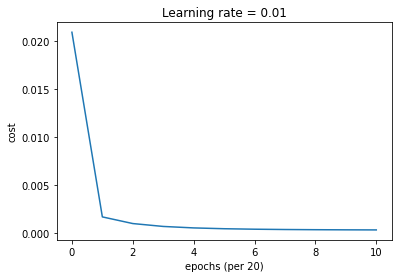

In [31]:
parameters = train(X_train,Y_train,80,lr = 0.01,lambd = 0.01) 

## Implementing on test dataset



In [32]:
predictions = predict(X_test,parameters)
accuracy(predictions,y_test)

Accuracy :  97.16666666666667


## Save as pickle

In [34]:
import pickle
import random
from google.colab import files

roll_num = "210100059" # enter ldap
hidden_dim = 80 # replace with your own hidden dimension

W1 = parameters["W1"]
W2 = parameters["W2"]
b1 = parameters["b1"]
b2 = parameters["b2"]

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': W1, # layer 0 weight (784, z)
    'layer_0_bias': b1, # layer 0 bias (z, 1)
    'layer_1_wt': W2, # layer 1 weight (z, 10)
    'layer_1_bias': b2 # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>